In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install pyspark
#!pip install gensim
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.clustering import LDA
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, col, expr, array_position, array_max
from pyspark.sql.types import ArrayType, FloatType, StringType, IntegerType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import regexp_replace
from pyspark.ml.clustering import LDA

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from pyspark.ml.linalg import SparseVector
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [ ]:
spark = SparkSession.builder \
    .appName("clustering_analysis") \
    .getOrCreate()
path = '/content/drive/Shareddrives/DDAM/Datasets aggiornati/df_filled.csv'

In [ ]:
df = spark.read.csv(path, header=True, inferSchema=True)
df.show(5)

+---------+----------+----------+----+-----------+-----------+--------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------------+--------------------+------+-----------+--------+--------+-------------------+-------+---------+-------------------+-----------+------+--------+--------+
|    DR_NO| Date Rptd|  DATE OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|        Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status|Status Desc|Crm Cd 3|Crm Cd 4|           LOCATION|    LAT|      LON|           TIME OCC|time_of_day|season|Crm Cd 1|Crm Cd 2|
+---------+----------+----------+----+-----------+-----------+--------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------------+--------------------+------+-----------+--------+--------+-------------------+-------+---------+--

In [ ]:
# Crm Cd Desc sorted by frequencies in descending order
value_counts = df.groupBy("Crm Cd Desc").count()
value_counts = value_counts.orderBy(F.desc("count"))
value_counts.show(200, truncate=False)

#There are 140 distinct categories, the majority of which contain fewer than 1,000 records!
distinct_categories = df.select("Crm Cd Desc").distinct().count()
print(f"Number of distinct categories: {distinct_categories}")


+--------------------------------------------------------+------+
|Crm Cd Desc                                             |count |
+--------------------------------------------------------+------+
|VEHICLE - STOLEN                                        |110804|
|BATTERY - SIMPLE ASSAULT                                |74688 |
|BURGLARY FROM VEHICLE                                   |61324 |
|THEFT OF IDENTITY                                       |60867 |
|VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) |59639 |
|BURGLARY                                                |57743 |
|ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT          |53395 |
|THEFT PLAIN - PETTY ($950 & UNDER)                      |51384 |
|INTIMATE PARTNER - SIMPLE ASSAULT                       |46696 |
|THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)         |39550 |
|THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)     |35677 |
|THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD|33707 |
|ROBBERY  

<ipython-input-23-c76d8f255cd2>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


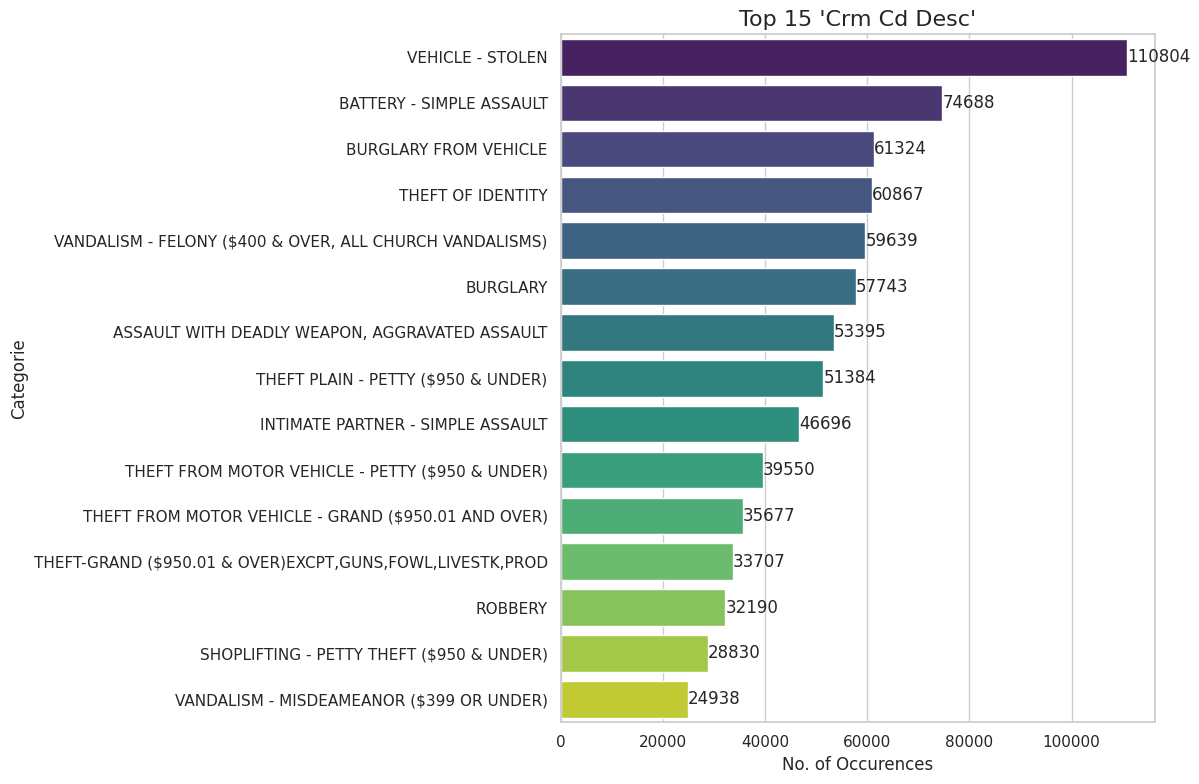

In [ ]:
# Using Pandas only for visualization purpose
# Top 15 categories of Crm Cd Desc. Many of them are about theft but with different estimated damages. They could be grouped somehow.
pandas_df = value_counts.toPandas()
top_15 = pandas_df.nlargest(15, "count")
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_15,
    y="Crm Cd Desc",
    x="count",
    palette="viridis",
    order=top_15.sort_values("count", ascending=False)["Crm Cd Desc"]
)

plt.title("Top 15 'Crm Cd Desc'", fontsize=16)
plt.xlabel("No. of Occurences", fontsize=12)
plt.ylabel("Categorie", fontsize=12)

for index, value in enumerate(top_15["count"]):
    plt.text(value, index, str(value), va="center")
plt.tight_layout()
plt.show()



In [ ]:
# Taking the text file in order to map the MO codes into meaningful text.
mapping_file = "/content/drive/Shareddrives/DDAM/3_Research_Question/MO_CODES_explanation.txt"

mapping_dict = {}
with open(mapping_file, 'r') as f:
    for line in f:
        line = line.strip()  # To remove redundant spaces
        if not line:  # if empty
            continue
        try:
            key, value = line.split(None, 1)
            mapping_dict[key] = value
        except ValueError:
            print(f"Riga mal formattata: '{line}'")


In [ ]:
#Just to visualize
for key, value in mapping_dict.items():
    print(f"{key}: {value}")

0100: Suspect Impersonate
0101: Aid victim
0102: Blind
0103: Physically disabled
0104: Customer
0105: Delivery
0106: Doctor
0107: God
0108: Infirm
0109: Inspector
0110: Involved in traffic/accident
0112: Police
0113: Renting
0114: Repair Person
0115: Returning stolen property
0116: Satan
0117: Salesman
0118: Seeking someone
0119: Sent by owner
0120: Social Security/Medicare
0121: DWP/Gas Company/Utility worker
0122: Contractor
0123: Gardener/Tree Trimmer
0200: Suspect wore disguise
0201: Bag
0202: Cap/hat
0203: Cloth (with eyeholes)
0204: Clothes of opposite sex
0205: Earring
0206: Gloves
0207: Handkerchief
0208: Halloween mask
0209: Mask
0210: Make up (males only)
0211: Shoes
0212: Nude/partly nude
0213: Ski mask
0214: Stocking
0215: Unusual clothes
0216: Suspect wore hood/hoodie
0217: Uniform
0218: Wig
0219: Mustache-Fake
0220: Suspect wore motorcycle helmet
0301: Escaped on (used) transit train
0302: Aimed gun
0303: Ambushed
0304: Ate/drank on premises
0305: Attacks from rear
0306: 

In [ ]:
# Broadcasting the dictionary: good for sharing static, read-only data efficiently across a Spark cluster
broadcast_mapping = spark.sparkContext.broadcast(mapping_dict)

In [ ]:
#  Creating a function that maps codes into text
def map_code_to_word(codes):
    if codes is None or codes.strip() == "":
        return "No Code"  # O un valore predefinito
    code_list = codes.split(" ")
    meanings = [broadcast_mapping.value.get(code, "Unknown Code") for code in code_list]
    return " ".join(meanings)
map_udf = udf(map_code_to_word, StringType())

# Updating the DataFrame
df_with_words = df.withColumn("Meaning", map_udf(df["MOCODES"]))
df_with_words.select('Mocodes','Meaning').show(truncate = False)

+-----------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Mocodes                      |Meaning                                                                                                                                                          |
+-----------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1822 0100 0344               |Stranger Suspect Impersonate Removes vict property                                                                                                               |
|0344                         |Removes vict property                                                                                                                                            |
|0522 1258 0602 0360 0551 0913

**End of the First Part: MO codes into TEXT**

--------------------------------------------------------------------------

**Second Part: Feature pre-processing and Feature selection - LDA algorithm**

In [ ]:
df_with_words.show(2)

In [ ]:
# Removing parenthesis and numbers (in order to give a cleaned input to the clustering algorithms)
df_with_words = df_with_words.withColumn(
    "Crm Desc_formatted",
    regexp_replace("Crm Cd Desc", r"\s*\([^)]*\)|\d+", "")  # Elimina parentesi e numeri
)
df_with_words = df_with_words.withColumn(
    "Premis Desc_formatted",
    regexp_replace("Premis Desc", r"\s*\([^)]*\)|\d+", "")
)
df_with_words = df_with_words.withColumn(
    "Weapon Desc_formatted",
    regexp_replace("Weapon Desc", r"\s*\([^)]*\)|\d+", "")
)
df_with_words = df_with_words.withColumn(
    "Meaning_formatted",
    regexp_replace("Meaning", r"\s*\([^)]*\)|\d+", "")
)
df_with_words.show(10, truncate = False)

+---------+----------+----------+----+-----------+-----------+--------+-------------------------------------------------------+-----------------------------+--------+--------+----------------------+---------+--------------------------------------------+--------------+----------------------------------------------+------+------------+--------+--------+-------------------+-------+---------+-------------------+-----------+------+--------+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------+------------------------------------+---------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|DR_NO    |Date Rptd |DATE OCC  |AREA|AREA NAME  |Rpt Dist No|Part 1-2|Crm Cd Desc                                 

In [ ]:
# Another cleaning step
df_with_words = df_with_words.select('DR_NO','Crm Desc_formatted','Premis Desc_formatted','Weapon Desc_formatted','Meaning_formatted')

df = df_with_words.withColumn("Weapon_Desc_Updated", F.regexp_replace("Weapon Desc_formatted", "NO WEAP", "NO_WEAP"))
df = df.withColumn("text", F.concat_ws(" ", F.col("Crm Desc_formatted"), F.col("Premis Desc_formatted"), F.col("Weapon_Desc_Updated"), F.col("Meaning_formatted")))
df.select('text').show(1, truncate = False)

df = df.select('DR_NO','text')

# Tokenization step
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
df = tokenizer.transform(df)
df.show(1, truncate = False)
df = df.select('DR_NO','tokens','text')

# Stopwords removal step (Some terms were added manually after some trials)
custom_stopwords = {"vict", "susp", "-", "etc", "no_weap", "&", "mo", ")", "(", "any", "also","is/was", "w/", "crm", "agnst", "victim", "victim's", "thru", "b/w", "use", "uses", "used"}
default_stopwords = StopWordsRemover.loadDefaultStopWords("english")
all_stopwords = list(set(default_stopwords).union(custom_stopwords))
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
remover = remover.setStopWords(all_stopwords)

#Update step
df = remover.transform(df)
df.show(1, truncate = False)
df = df.select('DR_NO','filtered_tokens')

# Vectorizer step: after this step, now data are ready to be processed by clustering algorithm.
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="features")
model = vectorizer.fit(df)
df = model.transform(df)
df.show(1, truncate=False)
df = df.select('DR_NO','features','filtered_tokens')



+---------------------------------------------------------------------------------------------------+
|text                                                                                               |
+---------------------------------------------------------------------------------------------------+
|THEFT OF IDENTITY SINGLE FAMILY DWELLING NO_WEAP Stranger Suspect Impersonate Removes vict property|
+---------------------------------------------------------------------------------------------------+
only showing top 1 row

+---------+---------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|DR_NO    |text                                                                                               |tokens                                                                                                           |
+---------+---

**End of the second part**

-------------------------------------------------------------------------------

**Third part: LDA**


In [ ]:
# Hyperparameter tuning: finding the best k for LDA
results = []
k_values = [5, 10, 15, 20, 25]

for k in k_values:

    lda = LDA(k=k, maxIter=10, seed=1, featuresCol="features")
    lda_model = lda.fit(df)

    # Evaluation
    log_likelihood = lda_model.logLikelihood(df)
    perplexity = lda_model.logPerplexity(df)

    print(f"Number of Topics: {k}")
    print(f"Log-Likelihood: {log_likelihood}")
    print(f"Perplexity: {perplexity}\n")


Number of Topics: 5
Log-Likelihood: -50031846.28925456
Perplexity: 4.703104017697097

Number of Topics: 10
Log-Likelihood: -48408850.88154504
Perplexity: 4.550538865922117

Number of Topics: 15
Log-Likelihood: -47591595.310507834
Perplexity: 4.473715037806544

Number of Topics: 20
Log-Likelihood: -47197142.00842011
Perplexity: 4.436635556487441

Number of Topics: 25
Log-Likelihood: -46705122.174245745
Perplexity: 4.390384605732719



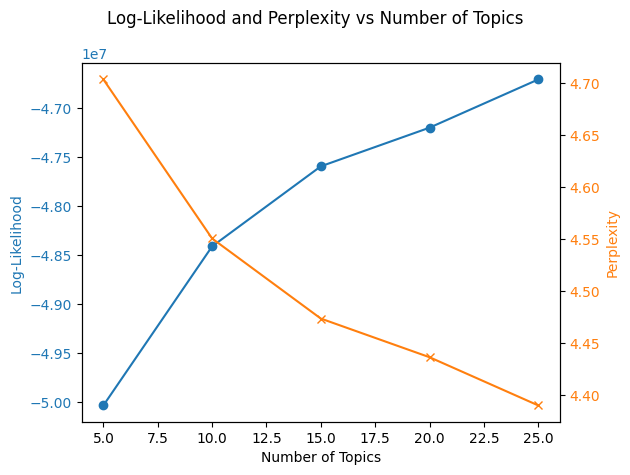

In [ ]:
# Plotting log-likelyhood and perplexity based on the value of k
num_topics = [5, 10, 15, 20, 25]
log_likelihood = [-50031846.28925456, -48408850.88154504, -47591595.310507834, -47197142.00842011, -46705122.174245745]
perplexity = [4.703104017697097, 4.550538865922117, 4.473715037806544, 4.436635556487441, 4.390384605732719]

fig, ax1 = plt.subplots()

ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Log-Likelihood', color='tab:blue')
ax1.plot(num_topics, log_likelihood, color='tab:blue', marker='o', label='Log-Likelihood')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Perplexity', color='tab:orange')
ax2.plot(num_topics, perplexity, color='tab:orange', marker='x', label='Perplexity')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.suptitle('Log-Likelihood and Perplexity vs Number of Topics')
fig.tight_layout()

plt.show()



In [ ]:
# LDA with the best k = 20
lda = LDA(k=20, maxIter=20, seed = 1, featuresCol="features", optimizeDocConcentration=True)
lda_model = lda.fit(df)

vocab = model.vocabulary
topics = lda_model.describeTopics(10)

for topic_id, topic in enumerate(topics.collect()):

    # Extracting the top words for each topic
    words = [vocab[word_id] for word_id in topic['termIndices']]
    print(f"Topic {topic_id}: {', '.join(words)}")

# Topic distribution: for each record we can see which is the probability that this record belongs to a certain topic (We will take the maximum probability and assign the associated label)
transformed = lda_model.transform(df)
transformed.select("DR_NO", "features",'filtered_tokens', "topicDistribution").show(truncate=False)

Topic 0: theft, dwelling, identity, stranger, family, single, number, unauthorized, multi-unit, suspect
Topic 1: suspect, violence, domestic, current/former, assault, partner, intimate, knew, strong-arm, dwelling
Topic 2: facility, transportation, office, abandoned, bomb, building/office, house, building, access, government
Topic 3: family, dwelling, single, suspect, weapon, aged, threaten, self, care, disabled/unable
Topic 4: , lewd, dwelling, stranger, property, removes, assault, family, burglary, single
Topic 5: years, old, , suspect, student, child, school, knew, strong-arm, weapon
Topic 6: robbery, property, stranger, removes, suspect, strong-arm, weapon, multi-susps, overwhelm, wore
Topic 7: vehicle, property, removes, street, stolen, theft, motor, suspect, grand, order
Topic 8: gun, weapon, stranger, takes, hand, brandishes, fedex,, usps, packages, ups,
Topic 9: suspect, strong-arm, sex, acts, sexual, knew, related, touched, contact, rape,
Topic 10: suspect, assault, dwelling, m

In [ ]:
# Retrieve topics described as indices and weights
topics = lda_model.describeTopics(maxTermsPerTopic=10)

# Collect the data into a list
topics_list = topics.rdd.map(lambda row: row['termIndices']).collect()

# Convert indices to words using the CountVectorizer vocabulary
vocab = model.vocabulary  # From the CountVectorizer used to generate features
word_topics = [[vocab[word] for word in topic] for topic in topics_list]

# Tokenized documents
tokenized_documents = df.select("filtered_tokens").rdd.flatMap(lambda x: x).collect()

# Create the Gensim dictionary
dictionary = Dictionary(tokenized_documents)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]


In [ ]:
# Create a Gensim dictionary
dictionary = Dictionary(tokenized_documents)

# Create a bag-of-words for each document
corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

# Coherence Score
coherence_model = CoherenceModel(topics=word_topics, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')

# Calculate the average coherence score
coherence_score = coherence_model.get_coherence()
print(f"Average Coherence Score: {coherence_score}")

# Calculate the coherence score for each topic
topic_coherence_scores = coherence_model.get_coherence_per_topic()
for i, score in enumerate(topic_coherence_scores):
    print(f"Coherence Score for Topic {i}: {score}")


Average Coherence Score: 0.5649493659584686
Coherence Score for Topic 0: 0.6275274361500494
Coherence Score for Topic 1: 0.9279917487088472
Coherence Score for Topic 2: 0.15351427118532432
Coherence Score for Topic 3: 0.6940229638616496
Coherence Score for Topic 4: 0.3144676431323075
Coherence Score for Topic 5: 0.8092839226062744
Coherence Score for Topic 6: 0.5436902589970024
Coherence Score for Topic 7: 0.4084488324990671
Coherence Score for Topic 8: 0.4014711604861585
Coherence Score for Topic 9: 0.810351663308065
Coherence Score for Topic 10: 0.6151988483528112
Coherence Score for Topic 11: 0.716525956316479
Coherence Score for Topic 12: 0.6356832688272741
Coherence Score for Topic 13: 0.8035070992064333
Coherence Score for Topic 14: 0.27691688390586067
Coherence Score for Topic 15: 0.48011662725901677
Coherence Score for Topic 16: 0.6086258038942448
Coherence Score for Topic 17: 0.26397818074416934
Coherence Score for Topic 18: 0.6507073306535933
Coherence Score for Topic 19: 0.5

In [ ]:
coherence_scores = []

# Iterating over different values of k
for k in [5, 10, 15, 20, 25]:
    lda = LDA(k=k, maxIter=10, seed=1, featuresCol="features")
    lda_model = lda.fit(df)

    # Extracting the most frequent topics
    topics = lda_model.describeTopics(maxTermsPerTopic=10)
    topics_list = topics.rdd.map(lambda row: row['termIndices']).collect()
    word_topics = [[vocab[word] for word in topic] for topic in topics_list]

    # Calculating the coherence scores
    coherence_model = CoherenceModel(topics=word_topics, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

    print(f"Number of Topics: {k}")
    print(f"Coherence Score: {coherence_score}\n")



Number of Topics: 5
Coherence Score: 0.4760305115711822

Number of Topics: 10
Coherence Score: 0.535163116576497

Number of Topics: 15
Coherence Score: 0.5434760413207552

Number of Topics: 20
Coherence Score: 0.5706694110460029

Number of Topics: 25
Coherence Score: 0.5395240246801787



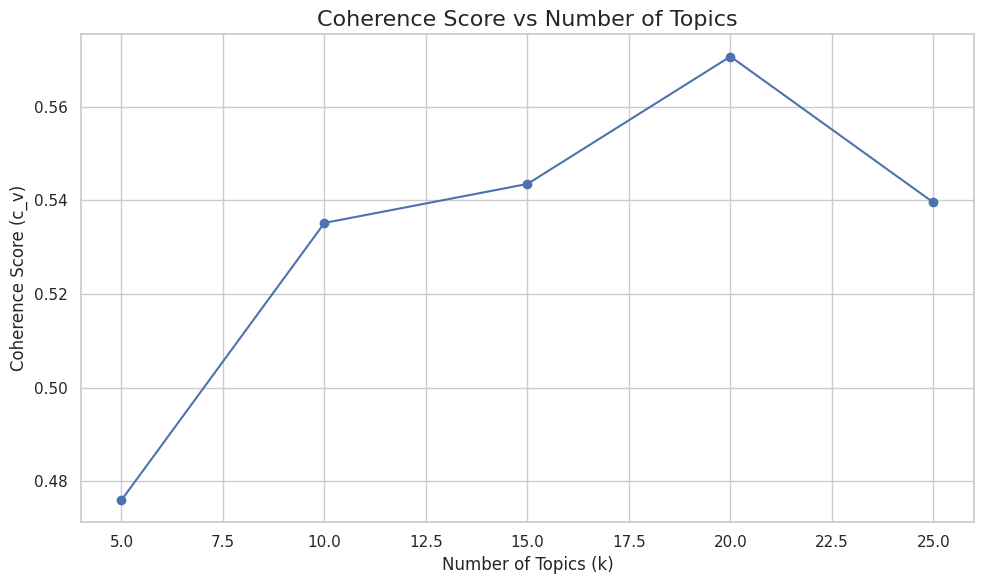

In [ ]:
# Plotting coherence scores base on the value of K
# Best k = 20
plt.figure(figsize=(10, 6))
plt.plot(k_values, coherence_scores, marker="o", linestyle="-", color="b")

plt.title("Coherence Score vs Number of Topics", fontsize=16)
plt.xlabel("Number of Topics (k)", fontsize=12)
plt.ylabel("Coherence Score (c_v)", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, array_position, array_max
from pyspark.ml.functions import vector_to_array # Import vector_to_array

transformed = lda_model.transform(df)
# Convert 'topicDistribution' vector to an array
df_finale = transformed.withColumn(
    "topicDistributionArray", vector_to_array("topicDistribution")
)

# Apply array_max and array_position to the extracted array
df_finale = df_finale.withColumn(
    "max_prob", array_max(col("topicDistributionArray"))
)

# Use expr to apply array_position to the array column
df_finale = df_finale.withColumn(
    "topic",
    expr("array_position(topicDistributionArray, max_prob) - 1") # Use expr to apply array_position
)

# Mostrare il risultato
df_finale.select('DR_NO','filtered_tokens', 'max_prob', 'topic').show(truncate=False)
df_finale.groupBy('topic').count().orderBy('count', ascending=False).show()






+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+-----+
|DR_NO    |filtered_tokens                                                                                                                                                                                                                |max_prob           |topic|
+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+-----+
|231817823|[theft, identity, single, family, dwelling, stranger, suspect, impersonate, removes, property]                                                                                                             

In [ ]:
topic_names = {
    0: "Identity and Property Theft in Residences",
    1: "Domestic Violence and Relational Assaults",
    2: "Security in Public and Government Facilities",
    3: "Protection of Families and Vulnerable Individuals",
    4: "Trespassing or Lewd Behavior in Residences",
    5: "Hate Crimes and Bias-Driven Offenses",
    6: "Violent Robberies and Group Offenses",
    7: "Vehicle Theft and Associated Property",
    8: "Armed Robberies",
    9: "Sexual Offenses",
    10: "Violent Home Intrusions",
    11: "Shoplifting and Minor Thefts",
    12: "Vandalism and Vehicle-Related Thefts",
    13: "Crimes Against Minors",
    14: "Arson and Public Disturbance",
    15: "Minor Thefts in Parking Areas",
    16: "Vandalism Targeting Vehicles",
    17: "Crimes in Health or Religious Facilities",
    18: "Violent Assaults with Weapons",
    19: "Crimes in Public Transit and Food Establishments"
}


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Crea una funzione UDF per mappare i topic ai loro nomi
def map_topic(topic_id):
    return topic_names.get(topic_id, "Unknown Topic")

# Registra l'UDF
map_topic_udf = udf(map_topic, StringType())

# Applica l'UDF al DataFrame
df_finale = df_finale.withColumn("topic_name", map_topic_udf(col("topic")))

# Mostra il risultato con i nomi dei topic
df_finale.select("DR_NO", "filtered_tokens", "topic", "topic_name").show(truncate=False)

# Opzionale: Visualizza la distribuzione dei topic con i loro nomi
df_finale.groupBy("topic_name").count().orderBy("count", ascending=False).show(truncate=False)


+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+-------------------------------------------------+
|DR_NO    |filtered_tokens                                                                                                                                                                                                                |topic|topic_name                                       |
+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+-------------------------------------------------+
|231817823|[theft, identity, single, family, dwelling, stranger, suspect, impersonate, removes, property]                   

**End of the third part**


---------------------------------------------

**K-MEANS**

-------------------------------------------------------------------

Same preprocessing stuff as LDA

In [ ]:
df = spark.read.csv(path, header=True, inferSchema=True)
df.show(5)

def map_code_to_word(codes):
    if codes is None or codes.strip() == "":
        return "No Code"
    code_list = codes.split(" ")
    meanings = [broadcast_mapping.value.get(code, "Unknown Code") for code in code_list]
    return " ".join(meanings)

map_udf = udf(map_code_to_word, StringType())

df_with_words = df.withColumn("Meaning", map_udf(df["MOCODES"]))
df_with_words.select('Mocodes','Meaning').show(truncate = False)

from pyspark.sql.functions import regexp_replace

df_with_words = df_with_words.withColumn(
    "Crm Desc_formatted",
    regexp_replace("Crm Cd Desc", r"\s*\([^)]*\)|\d+", "")
)
df_with_words = df_with_words.withColumn(
    "Premis Desc_formatted",
    regexp_replace("Premis Desc", r"\s*\([^)]*\)|\d+", "")
)
df_with_words = df_with_words.withColumn(
    "Weapon Desc_formatted",
    regexp_replace("Weapon Desc", r"\s*\([^)]*\)|\d+", "")
)
df_with_words = df_with_words.withColumn(
    "Meaning_formatted",
    regexp_replace("Meaning", r"\s*\([^)]*\)|\d+", "")
)
df_with_words.show(10, truncate = False)

+---------+----------+----------+----+-----------+-----------+--------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------------+--------------------+------+-----------+--------+--------+-------------------+-------+---------+-------------------+-----------+------+--------+--------+
|    DR_NO| Date Rptd|  DATE OCC|AREA|  AREA NAME|Rpt Dist No|Part 1-2|         Crm Cd Desc|             Mocodes|Vict Age|Vict Sex|        Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status|Status Desc|Crm Cd 3|Crm Cd 4|           LOCATION|    LAT|      LON|           TIME OCC|time_of_day|season|Crm Cd 1|Crm Cd 2|
+---------+----------+----------+----+-----------+-----------+--------+--------------------+--------------------+--------+--------+--------------------+---------+--------------------+--------------+--------------------+------+-----------+--------+--------+-------------------+-------+---------+--

In [ ]:
df_with_words = df_with_words.select('DR_NO','Crm Desc_formatted','Premis Desc_formatted','Weapon Desc_formatted','Meaning_formatted')
df = df_with_words.withColumn("Weapon_Desc_Updated", F.regexp_replace("Weapon Desc_formatted", "NO WEAP", "NO_WEAP"))
df = df.withColumn("text", F.concat_ws(" ", F.col("Crm Desc_formatted"), F.col("Premis Desc_formatted"), F.col("Weapon_Desc_Updated"), F.col("Meaning_formatted")))
df.select('text').show(1, truncate = False)
df = df.select('DR_NO','text')

# Tokenizer
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
df = tokenizer.transform(df)
df.show(1, truncate = False)
df = df.select('DR_NO','tokens','text')

# Stopword removal
custom_stopwords = {"vict", "susp", "-", "etc", "no_weap", "&", "mo", ")", "(", "any", "also","is/was", "w/", "crm", "agnst", "victim", "victim's", "thru", "b/w", "use", "uses", "used"}
# Combina le stopwords predefinite con quelle personalizzate
default_stopwords = StopWordsRemover.loadDefaultStopWords("english")
all_stopwords = list(set(default_stopwords).union(custom_stopwords))

remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
remover = remover.setStopWords(all_stopwords)

# Updating step
df = remover.transform(df)
df.show(1, truncate = False)
filtered_df = df.select('DR_NO','filtered_tokens')

# Vectorizer
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="features")
model2 = vectorizer.fit(filtered_df)
df = model2.transform(filtered_df)
df.show(1, truncate=False)
df = df.select('DR_NO','features','filtered_tokens')


+---------------------------------------------------------------------------------------------------+
|text                                                                                               |
+---------------------------------------------------------------------------------------------------+
|THEFT OF IDENTITY SINGLE FAMILY DWELLING NO_WEAP Stranger Suspect Impersonate Removes vict property|
+---------------------------------------------------------------------------------------------------+
only showing top 1 row

+---------+---------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|DR_NO    |text                                                                                               |tokens                                                                                                           |
+---------+---

In [ ]:
# Define a UDF to calculate the size of the non-zero entries in a SparseVector
def vector_nonzero_size(v):
    if isinstance(v, SparseVector):
        return len(v.indices)
    else:
        return 0

# Register the UDF
nonzero_size_udf = udf(vector_nonzero_size, IntegerType())

# Apply the UDF to calculate the size of the non-zero entries
vector_sizes = df.withColumn("vector_size", nonzero_size_udf(col("features")))
vector_sizes.select("vector_size").describe().show()



+-------+------------------+
|summary|       vector_size|
+-------+------------------+
|  count|            982638|
|   mean| 10.24751943238507|
| stddev|4.7276052331928575|
|    min|                 2|
|    max|                39|
+-------+------------------+



In [ ]:
#Converts tokenized text into a sparse numerical feature vector using the hashing trick (to reduce memory usage)
hashing_tf = HashingTF(inputCol="filtered_tokens", outputCol="raw_features", numFeatures=1000)
featurized_data = hashing_tf.transform(filtered_df)

#Scales the feature vectors by down-weighting terms that appear frequently across all documents.
idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(featurized_data)
final_data = idf_model.transform(featurized_data)

In [ ]:
# List of k values to test
k_values = [10, 15, 20, 25]

# List to store the results
results = []

# Loop to test different values of k
for k in k_values:
    print(f"Testing k = {k}")

    # KMeans model configuration
    kmeans = KMeans(k=k, seed=1, featuresCol="features")
    model = kmeans.fit(final_data)

    # Predictions
    predictions = model.transform(final_data)

    # Calculating the silhouette score
    evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
    silhouette_score = evaluator.evaluate(predictions)

    # Adding the result to the list
    results.append((k, silhouette_score))
    print(f"Silhouette Score for k = {k}: {silhouette_score}")

results_df = spark.createDataFrame(results, ["k", "silhouette_score"])
results_df.show()

# Find the best k based on the silhouette score
best_k = results_df.orderBy(col("silhouette_score").desc()).first()
print(f"The best k is {best_k['k']} with a silhouette score of {best_k['silhouette_score']}")



Testing k = 10
Silhouette Score for k = 10: 0.022390987259040273
Testing k = 15
Silhouette Score for k = 15: 0.010266899733317935
Testing k = 20
Silhouette Score for k = 20: 0.08093968519509862
Testing k = 25
Silhouette Score for k = 25: -0.005320830427927072
+---+--------------------+
|  k|    silhouette_score|
+---+--------------------+
| 10|0.022390987259040273|
| 15|0.010266899733317935|
| 20| 0.08093968519509862|
| 25|-0.00532083042792...|
+---+--------------------+

The best k is 20 with a silhouette score of 0.08093968519509862


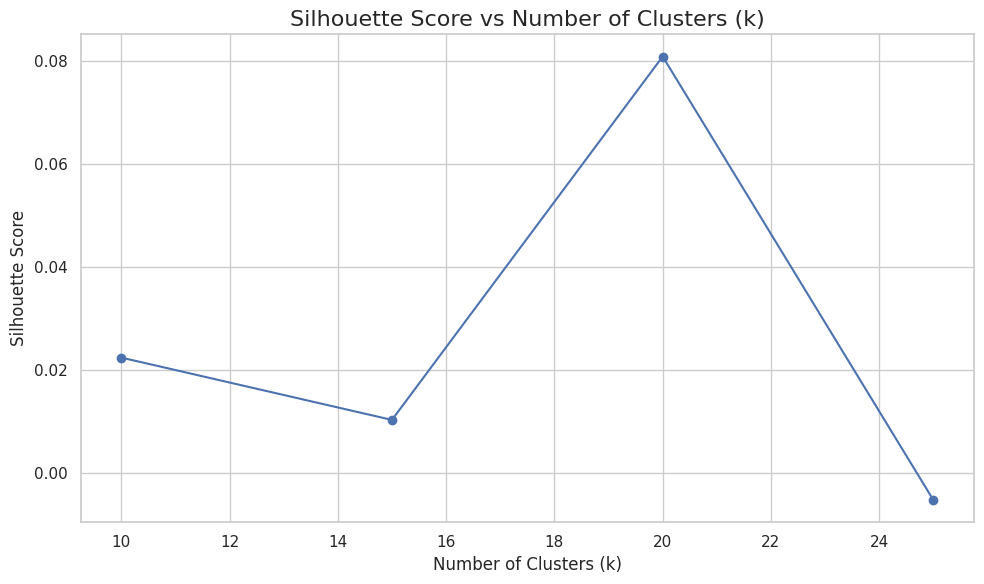

In [ ]:
import matplotlib.pyplot as plt

# silhouette score by changing k
k_values = [10, 15, 20, 25]
silhouette_scores = [0.022390987259040273, 0.010266899733317935, 0.08093968519509862, -0.005320830427927072]
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker="o", linestyle="-", color="b")

plt.title("Silhouette Score vs Number of Clusters (k)", fontsize=16)
plt.xlabel("Number of Clusters (k)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
#K-Means with the best K=20
kmeans = KMeans(k=20, seed=1, featuresCol="features")
model = kmeans.fit(final_data)

# Get the cluster assignments
clusters = model.transform(final_data)
clusters.select("DR_NO","filtered_tokens", "prediction").show()

+---------+--------------------+----------+
|    DR_NO|     filtered_tokens|prediction|
+---------+--------------------+----------+
|231817823|[theft, identity,...|        11|
|200215463|[vehicle, stolen,...|        11|
|220207142|[battery, sexual,...|        15|
|231214452|[theft, identity,...|        11|
|221508746|[vandalism, felon...|        10|
|220409179|[theft, identity,...|        11|
|220318344|[theft, identity,...|        11|
|222005532|[sodomy/sexual, c...|         2|
|201908081|[violation, restr...|        11|
|201517780|[arson, street, r...|        11|
|200508041|[intimate, partne...|         6|
|200916764|[battery, simple,...|        18|
|200507883|[burglary, vehicl...|        17|
|201305727|[assault, deadly,...|         4|
|200513050|[vandalism, felon...|         2|
|200909602|[vehicle, stolen,...|        11|
|200114122|[burglary, vehicl...|        17|
|200906674|[theft, plain, pe...|         1|
|201704162|[assault, deadly,...|         4|
|200706875|[theft, identity,...|

In [ ]:
# Silhouette score
evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = evaluator.evaluate(clusters)
print(f"Silhouette Score: {silhouette}")


Silhouette Score: 0.0951806601408926


In [ ]:
# Internal composition
clusters.groupBy("prediction").count().show()


+----------+------+
|prediction| count|
+----------+------+
|        12|   556|
|         1|  5082|
|        13| 43908|
|         6| 47493|
|        16|  8284|
|         3| 13073|
|         5| 33014|
|        19| 10528|
|        15| 15242|
|        17| 31590|
|         9| 13374|
|         4| 55294|
|         8|  6416|
|         7| 15529|
|        10| 66002|
|        11|469928|
|        14| 92653|
|         2| 20908|
|         0| 25336|
|        18|  8428|
+----------+------+



In [ ]:
from pyspark.ml.linalg import DenseVector
import numpy as np

# Getting centroids
centroids = model.clusterCenters()

# Printing centroids
vocab = model2.vocabulary
for i, center in enumerate(centroids):
    print(f"Cluster {i}:")

    top_indices = np.argsort(center)[-10:][::-1]  # Top 10 words
    top_words = [(vocab[idx], center[idx]) for idx in top_indices]
    for word, weight in top_words:
        print(f"  {word}: {weight}")



Cluster 0:
  choked/uses: 3.528947129396566
  coffee: 3.5068876724289013
  threw: 2.496593048942404
  orientation: 2.3662667401132405
  bias:: 2.2849896245571513
  calls,: 1.241539932283428
  bullets/casings: 1.1100989170667601
  disables: 0.8670656853413834
  apartment/condo: 0.7683769503771547
  act: 0.5864122605455262
Cluster 1:
  handkerchief: 5.265395149089096
  fedex,: 5.25432153704757
  bite: 5.234111169137236
  harrassing: 5.083593727841975
  vermont/beverly: 4.93551166469579
  current/former: 4.562360358521197
  food: 1.8281498975216655
  trespassing: 1.8059939199188533
  banking,: 1.2004169017272979
  mailbox: 0.9265481833556313
Cluster 2:
  theft:: 6.380497222293044
  suggestive: 5.777560173730364
  traffic: 3.5747068264076414
  bullets/casings: 2.0143502147958454
  instrument/chain: 1.7379925582177647
  photographs: 1.474032440496514
  clerk/employer/owner: 0.9820091544747052
  object: 0.9286321522565903
  sword: 0.9028198946577629
  jumped: 0.7833657632665764
Cluster 3:
  

In [ ]:
# Visualizing a cluster
#clusters.filter(clusters["prediction"] == 11).select("DR_NO", "filtered_tokens").show(truncate=False)


+---------+------------------------------------------------------------------------------------------------------------+
|DR_NO    |filtered_tokens                                                                                             |
+---------+------------------------------------------------------------------------------------------------------------+
|231817823|[theft, identity, single, family, dwelling, stranger, suspect, impersonate, removes, property]              |
|200215463|[vehicle, stolen, street, removes, property]                                                                |
|221508746|[vandalism, felony, elementary, school, vehicle, involved, vandalized]                                      |
|220409179|[theft, identity, premise, suspect, impersonate]                                                            |
|220318344|[theft, identity, single, family, dwelling, stranger, suspect, impersonate]                                 |
|201908081|[violation, restraini

In [ ]:
# Define the cluster mapping dictionary
cluster_mapping = {
    0: "Domestic or Physical Altercations",
    1: "Workplace or Service Incidents",
    2: "Theft and Suggestive Behavior",
    3: "Family or Interpersonal Conflicts",
    4: "Public or Media-Related Crimes",
    5: "Real Estate or Property Crimes",
    6: "Discrimination and Personal Spaces",
    7: "Educational or Social Venues",
    8: "Stalking and Workplace Issues",
    9: "Domestic and Physical Threats",
    10: "Weapons and Confrontations",
    11: "Minor Offenses or Vandalism",
    12: "Infrastructure and Transit Incidents",
    13: "Violence and Sexual Misconduct",
    14: "Harassment and Property Issues",
    15: "Utilities and Public Spaces",
    16: "Aggression and Intimidation",
    17: "Cyber and Verbal Harassment",
    18: "Sexual Violence",
    19: "Identity and Media-Related Crimes"
}

# Create a UDF to map cluster IDs to cluster names
#def get_cluster_name(cluster_id):
#    return cluster_mapping.get(cluster_id, "Unknown Cluster")

# Register the UDF
#get_cluster_name_udf = udf(get_cluster_name, StringType())

# Effettua il join tra il dataset principale e i cluster
#df_with_prediction = df.join(
#    clusters.select("DR_NO", "prediction"),  # Seleziona solo DR_NO e prediction
#    on="DR_NO",  # Colonna per il join
#    how="left"   # Mantiene tutte le righe di df
#)

# Aggiungi la colonna con i nomi dei cluster
#df_with_cluster_names = df_with_prediction.withColumn(
#    "cluster_name",
#    get_cluster_name_udf(df_with_prediction["prediction"])  # Applica la UDF sulla colonna "prediction"
#)

# Mostra il risultato
#df_with_cluster_names.show(truncate=False)



+---------+----------+----------+----+-----------+-----------+--------+-------------------------------------------------------+-----------------------------+--------+--------+----------------------+---------+--------------------------------------------+--------------+----------------------------------------------+------+------------+--------+--------+-------------------+-------+---------+-------------------+-----------+------+--------+--------+----------+----------------------------------+
|DR_NO    |Date Rptd |DATE OCC  |AREA|AREA NAME  |Rpt Dist No|Part 1-2|Crm Cd Desc                                            |Mocodes                      |Vict Age|Vict Sex|Vict Descent          |Premis Cd|Premis Desc                                 |Weapon Used Cd|Weapon Desc                                   |Status|Status Desc |Crm Cd 3|Crm Cd 4|LOCATION           |LAT    |LON      |TIME OCC           |time_of_day|season|Crm Cd 1|Crm Cd 2|prediction|cluster_name                      |
+---------